In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

from astropy.visualization import (SqrtStretch, ImageNormalize)
from copy import deepcopy
from scipy.ndimage import rotate
import matplotlib.patches as patches
from matplotlib.path import Path

from scipy.optimize import minimize

In [2]:
def Get_PS1(RA, DEC,Size, filt='i'):
    '''
    Size limit seems to be around 1000
    '''
    if Size > 30:
        raise ValueError('Thats too big man')
    Scale = 100
    size = Size * Scale#int((Size + 2*np.sqrt(1/2)*Size) * Scale ) # last term is a fudge factor 
    fitsurl = sd.geturl(RA,DEC, size=size, filters=filt, format="fits")
    if len(fitsurl) > 0:
        fh = sd.fits.open(fitsurl[0])
        return fh[0]
    else:
        raise ValueError("No PS1 images at for this coordinate") 
        return 
    
def PS1_images(RA, DEC,Size,filt):
    images = {}
    for f in filt:
        im = Get_PS1(RA, DEC,Size,f)
        ima = im.data 
        ima[~np.isfinite(ima) | (ima < 0)] = 0
        images[f] = ima
        
        
    images['wcs'] = sd.WCS(im)
    
    return images

def Convolve_PS1(ps1,tpf,corners=None):
    
    #PRF = sd.Get_PRF(tpf.row + (12/2), tpf.column + (12/2),
    #          tpf.camera,tpf.ccd)
    PRF = sd.Interp_PRF(tpf.row + (12/2), tpf.column + (12/2),
                          tpf.camera,tpf.ccd,100)
    if corners is not None:
        x = corners[0,0,1] - corners[0,0,0]
        y = corners[1,0,1] - corners[1,0,0]
        ang = np.arctan(x/y)*180/np.pi
        PRF = rotate(np.fliplr(PRF),ang)
        
    conv = deepcopy(ps1)
    for key in list(ps1.keys())[:-1]:
        conv[key] = sd.signal.fftconvolve(ps1[key], PRF, mode='same')
    return conv

def Regrid_PS1(ps1,corners):
    grid = deepcopy(ps1)
    for key in list(ps1.keys())[:-1]:
        down = sd.Regrid_PS(ps1[key],corners).T
        down[down<=0] = 0
        grid[key] = down
    return grid

In [3]:
# SN2020amx
ra = 148.5706917
dec = 51.68126944
# host fqv
ra = 189.1428830     
dec = 11.2386300

size = 15
filts = ['g','r','i','z','y']
ps1 = sd.PS1_images(ra,dec,size,filts)

/Users/rri38/Documents/work/code/SynDiff/development/../scenes/ps1_funcs.py:179: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(ima) + 25 + 2.5*np.log10(im.header['EXPTIME'])
/Users/rri38/Documents/work/code/SynDiff/development/../scenes/ps1_funcs.py:113: RuntimeWarning: divide by zero encountered in divide
  cz*ps1['z'] + cy*ps1['y'])*(ps1['g']/ps1['i'])**cp)
/Users/rri38/Documents/work/code/SynDiff/development/../scenes/ps1_funcs.py:113: RuntimeWarning: invalid value encountered in divide
  cz*ps1['z'] + cy*ps1['y'])*(ps1['g']/ps1['i'])**cp)
/Users/rri38/Documents/work/code/SynDiff/development/../scenes/ps1_funcs.py:112: RuntimeWarning: invalid value encountered in multiply
  fit = ((cg*ps1['g'] + cr*ps1['r'] + ci*ps1['i'] +
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this for

<IPython.core.display.Javascript object>


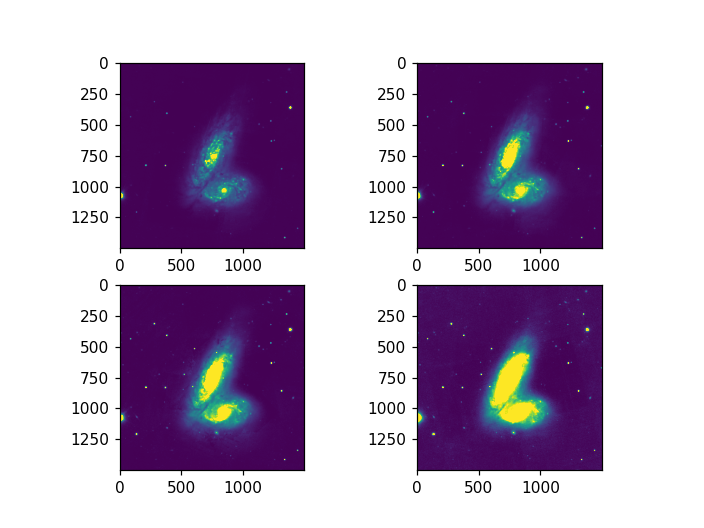

In [15]:
plt.figure()
plt.subplot(221)
plt.imshow(ps1['g'],vmin=0,vmax=5)
plt.subplot(222)
plt.imshow(ps1['r'],vmin=0,vmax=5)
plt.subplot(223)
plt.imshow(ps1['i'],vmin=0,vmax=5)
plt.subplot(224)
plt.imshow(ps1['y'],vmin=0,vmax=5)

In [6]:
tpf = sd.Get_TESS(ra,dec,13)
tess_corners = sd.Get_TESS_corners(tpf, ps1['wcs'])

/Users/rri38/miniconda3/lib/python3.9/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<IPython.core.display.Javascript object>


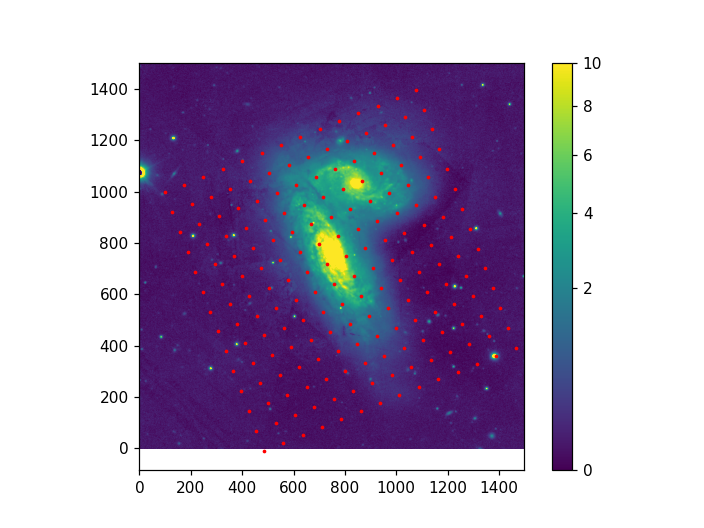

In [7]:
norm = ImageNormalize(vmin=0, 
                      vmax=10, stretch=SqrtStretch())

plt.figure()
#plt.subplot(projection=wcs)
plt.imshow(ps1['i'],origin='lower',norm=norm)
plt.colorbar()
plt.scatter(tess_corners[0,:,:].flatten(),tess_corners[1,:,:].flatten(),c='r',s=2)

In [9]:
def Get_TESS_corners(TESS,PS1_wcs):
    x,y = TESS.flux.shape[1:]
    # include the top corners for the last pixels
    x += 1; y += 1

    corners = np.zeros((2,x,y))
    ps_corners = np.zeros((2,x,y))
    x_arr = np.arange(0,x)
    y_arr = np.arange(0,y)

    for i in range(x):
        for j in range(y):
            corners[:,i,j] = sd.pix2coord(x_arr[i]+1,y_arr[j]+1,TESS.wcs) # why is this offset by 1????
            ps_corners[:,i,j] = sd.coord2pix(corners[0,i,j],corners[1,i,j],PS1_wcs)
            
    return ps_corners

In [29]:
def to_tess_counts(com,z1,z2):
    m = -2.5*np.log10(com) + z1
    f = 10**(-2/5*(m-z2))
    return f

ps1conv = sd.Convolve_PS1(ps1,tpf,tess_corners)
down = sd.Regrid_PS1(ps1,tess_corners)
fra = sd.PS1_tess_comp(down)
fra = to_tess_counts(fra,25,20.44)

In [169]:
from skimage.util.shape import view_as_windows
def downSample2d(arr,sf):
    """
    Downsample an array by a factor of sf.

    Parameters
    ----------
    arr : 2d numpy array
        Input array to be downsampled.
    sf : int
        Downsample factor.

    Returns
    -------
    arr_ds : 2d numpy array
        Downsampled array.
    """
    isf2 = 1.0/(sf*sf)
    (A,B) = arr.shape
    windows = view_as_windows(arr, (sf,sf), step = sf)
    return windows.sum(3).sum(2)*isf2

from scipy import signal
def fit_psf(var,ps1,tess,tess_corners):
    X = np.arange(0,11,1e-2)
    Y = np.arange(0,11,1e-2)
    XX, YY = np.meshgrid(X-0.5,Y-0.5)
    g2d = Gaussian2D(x_mean=var[0],y_mean=var[1],x_stddev=var[2],y_stddev=var[3],theta=var[4])
    g = g2d(XX,YY)
    g /= np.nansum(g)
    conv = signal.fftconvolve(ps1['tess'], g, mode='same')
    down = sd.Regrid_PS(conv,tess_corners).T
    down *= 10**var[5]
    diff = (down - tess)**2
    print(var)
    print('diff ',np.nansum(diff))
    return np.nansum(diff)

from scipy import signal
def fit_psf2(var,ps1,tess,tess_corners):
    X = np.arange(0,11,1e-2)
    Y = np.arange(0,11,1e-2)
    XX, YY = np.meshgrid(X-0.5,Y-0.5)
    g2d = Gaussian2D(x_mean=var[0],y_mean=var[1],x_stddev=var[2],y_stddev=var[3],theta=var[4])
    g = g2d(XX,YY)
    g /= np.nansum(g)
    g = downSample2d(g,100)
    conv = signal.fftconvolve(ps1, g, mode='same')
    down = sd.Regrid_PS(ps1['tess'],tess_corners).T
    fra *= 10**var[5]
    diff = (fra - tess)**2
    print(var)
    print('diff ',np.nansum(diff))
    return np.nansum(diff)

<IPython.core.display.Javascript object>


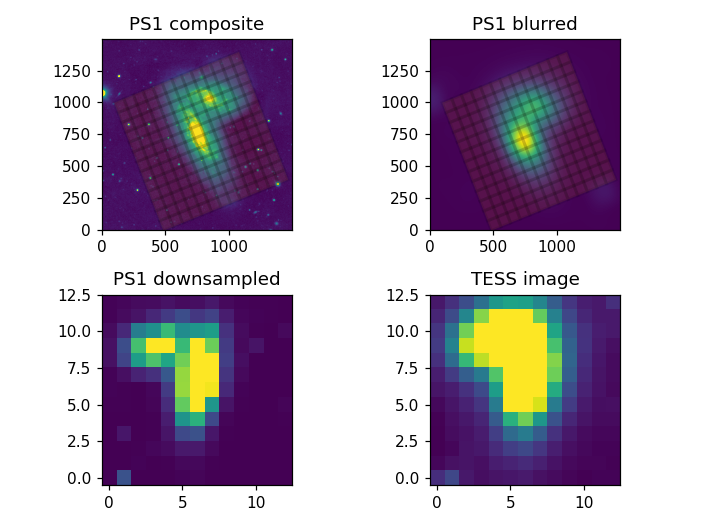

In [57]:
norm = ImageNormalize(vmin=0, 
                      vmax=10, stretch=SqrtStretch())
square = sd.Make_squares(tess_corners)
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(ps1['tess'],origin='lower',norm=norm)
ax[0,0].set_title('PS1 composite')
for a in square:
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
        ]
    a = a.vertices
    b = np.vstack((a,a[0]))
    test = Path(b,codes=codes)
    patch = patches.PathPatch(test, facecolor='orange', lw=2,alpha=0.1)
    ax[0,0].add_patch(patch)

ax[0,1].imshow(ps1conv['tess'],origin='lower')#,norm=norm)
ax[0,1].set_title('PS1 blurred')
for a in square:
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
        ]
    a = a.vertices
    b = np.vstack((a,a[0]))
    test = Path(b,codes=codes)
    patch = patches.PathPatch(test, facecolor='orange', lw=2,alpha=0.1)
    ax[0,1].add_patch(patch)
    
#plt.subplot(122)
#plt.imshow(tpf.flux[100],origin='lower')
vmin = np.percentile(fra,16); vmax = np.percentile(fra,95
                                                  )
ax[1,0].imshow(fra,origin='lower',vmin=vmin,vmax=vmax)
ax[1,0].set_title('PS1 downsampled')
ax[1,1].imshow(tpf.flux[100].value-603,origin='lower',vmin=vmin,vmax=vmax)
ax[1,1].set_title('TESS image')

plt.tight_layout()

<IPython.core.display.Javascript object>


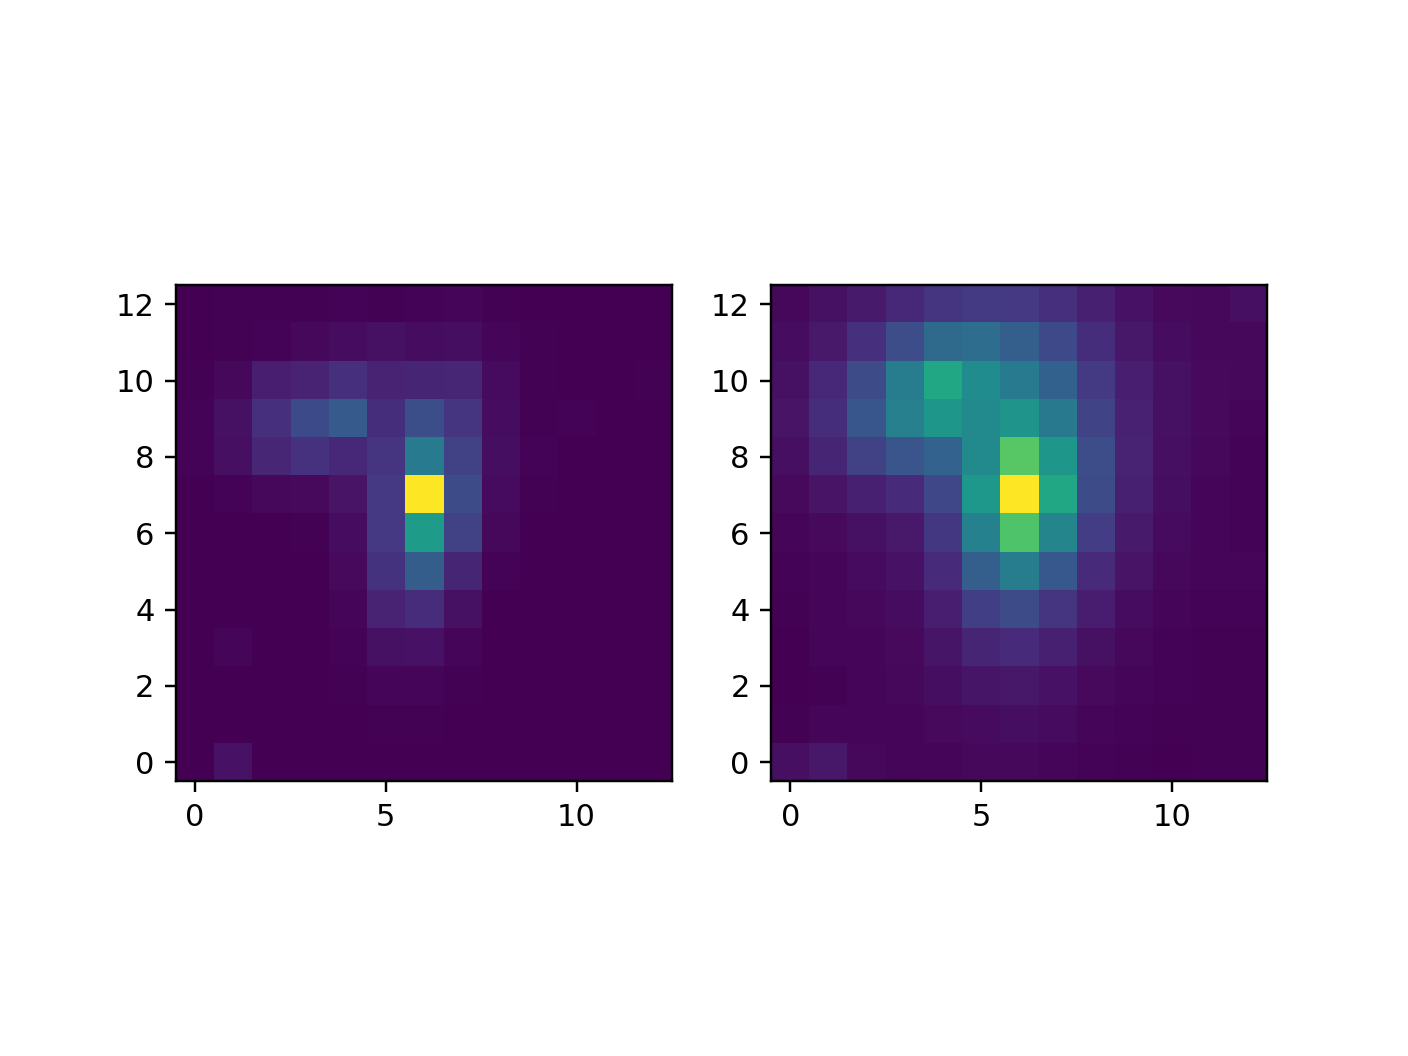

In [181]:
plt.figure()
plt.subplot(121)
plt.imshow(fra,origin='lower')
plt.subplot(122)
plt.imshow(tpf.flux[100].value,origin='lower')

## Incorherent jumble beyond this point trying to fit a PSF

In [20]:
from   scipy.stats import (multivariate_normal as mvn,
                           norm)

class multivariate_skewnorm:
    
    def __init__(self, a, cov=None):
        self.dim  = len(a)
        self.a    = np.asarray(a)
        self.mean = np.zeros(self.dim)
        self.cov  = np.eye(self.dim) if cov is None else np.asarray(cov)

    def pdf(self, x):
        return np.exp(self.logpdf(x))
        
    def logpdf(self, x):
        x    = mvn._process_quantiles(x, self.dim)
        pdf  = mvn(self.mean, self.cov).logpdf(x)
        cdf  = norm(0, 1).logcdf(np.dot(x, self.a))
        return np.log(2) + pdf + cdf

In [21]:
def fit_psf(c,ps1,tess):
    x = c[0]
    y = c[1]
    

In [22]:
xx  = np.arange(-6, 7, .01)

In [29]:
g = sd.Gaussian2D(1300,FWHM=1000)

In [55]:
xx   = np.arange(-6, 7, 0.01)
yy   = np.arange(-6, 7, 0.01)
X, Y = np.meshgrid(xx, yy)
pos  = np.dstack((X, Y))
a = [2,1]
Z = multivariate_skewnorm(a=a).pdf(pos)

In [108]:
def skewed(A):
    a = [A[0],A[1]]
    xx   = np.arange(-6, 7, 0.01)
    yy   = np.arange(-6, 7, 0.01)
    X, Y = np.meshgrid(xx, yy)
    pos  = np.dstack((X, Y))
    Z = multivariate_skewnorm(a=a).pdf(pos)
    return Z

<IPython.core.display.Javascript object>


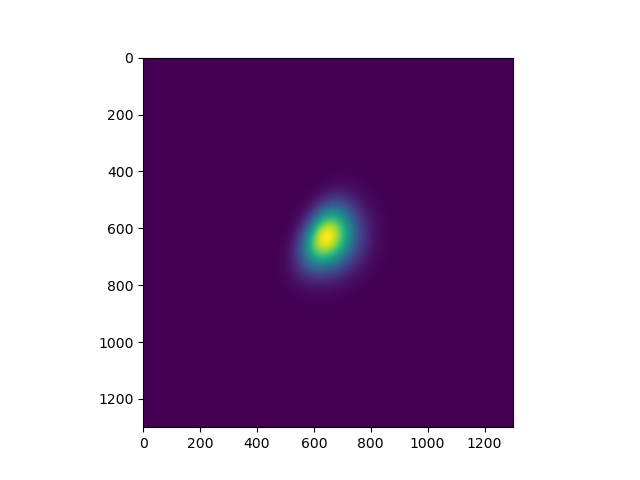

In [104]:
plt.figure()
plt.imshow(g*Z)

In [106]:
def fit_psf(c,ps1,tess,corners):
    print(c)
    sig = c[0]
    zp = c[1]
    a = [c[2],c[3]]
    g = sd.Gaussian2D(1300,FWHM=sig) * skewed(a)
    p = sd.signal.fftconvolve(ps1, g, mode='same')
    p = sd.Regrid_PS(p,corners).T
    p = 2.5*np.log10(p) + zp
    t = 2.5*np.log10(tess) #+ 20.44
    
    res = np.nansum(abs(t-p))
    print('res ',res)
    return res

    

In [122]:
com = sd.PS1_tess_comp(ps1)
d = sd.Regrid_PS(com,tess_corners).T
psf = sd.Get_PRF(tpf.row,tpf.column,tpf.camera,tpf.ccd)
p = sd.signal.convolve(d, psf.T, mode='same')

t = tpf.flux[100] - np.percentile(tpf.flux[100],1)

<IPython.core.display.Javascript object>


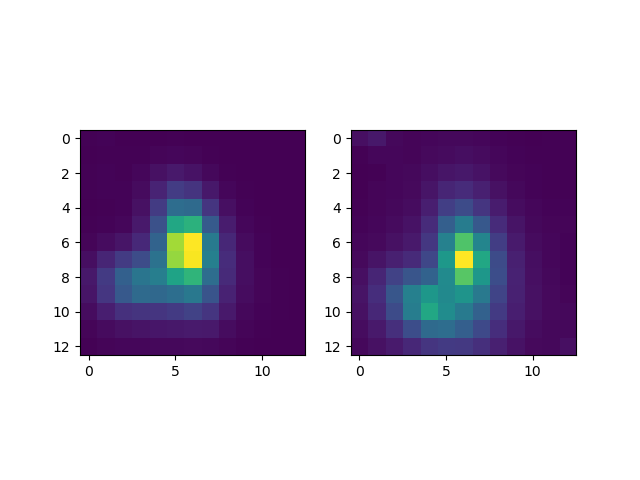

In [123]:
plt.figure()
plt.subplot(121)
plt.imshow(p)
plt.subplot(122)
plt.imshow(t)

In [109]:
com = sd.PS1_tess_comp(ps1)
t = tpf.flux[100] - np.percentile(tpf.flux[100],1)
c = [285,-16,0,0]
r = minimize(fit_psf,c,args=(com,t,tess_corners),method='Nelder-Mead')

[285. -16.   0.   0.]


/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


res  507.3335805238062
[299.25 -16.     0.     0.  ]
res  496.2405918455999
[285.  -16.8   0.    0. ]
res  640.9335805238062
[ 2.85e+02 -1.60e+01  2.50e-04  0.00e+00]
res  507.32658278014605
[ 2.85e+02 -1.60e+01  0.00e+00  2.50e-04]
res  507.32870682149786
[ 2.92125e+02 -1.52000e+01  1.25000e-04  1.25000e-04]
res  368.0435810367066
[ 2.956875e+02 -1.440000e+01  1.875000e-04  1.875000e-04]
res  232.15761500307534
[ 2.9746875e+02 -1.5200000e+01  2.1875000e-04  2.1875000e-04]
res  363.95817454342375
[ 3.03703125e+02 -1.48000000e+01  3.28125000e-04 -4.68750000e-05]
res  292.5852220159026
[ 3.13054688e+02 -1.42000000e+01  1.17187500e-04  1.79687500e-04]
res  187.10953917407699
[ 3.27082031e+02 -1.33000000e+01  5.07812500e-05  2.69531250e-04]
res  80.65615715357129
[ 3.12720703e+02 -1.28500000e+01  3.92578125e-04  3.14453125e-04]
res  84.97867976907295
[ 3.22127930e+02 -1.24750000e+01  2.60742188e-04  1.43554687e-04]
res  119.89243056328849
[ 3.25105957e+02 -1.17125000e+01  1.17675781e-04  5

res  77.01714381184388
[ 4.01953371e+02 -1.33622553e+01 -1.03209037e-03 -4.90429028e-04]
res  76.97129276688949
[ 4.15592931e+02 -1.34026978e+01 -1.23541591e-03 -6.20230568e-04]
res  76.94588999333993
[ 4.22891350e+02 -1.34211065e+01 -1.34884859e-03 -6.90504714e-04]
res  76.9818006838362
[ 4.07793276e+02 -1.33669767e+01 -1.12171441e-03 -5.30264909e-04]
res  76.98623379779994
[ 4.10244425e+02 -1.33932192e+01 -1.15040860e-03 -5.72447836e-04]
res  76.95263550304006
[ 4.21046907e+02 -1.34221701e+01 -1.30875650e-03 -6.67354097e-04]
res  76.98356481472842
[ 4.06726755e+02 -1.33772340e+01 -1.10125690e-03 -5.34660295e-04]
res  76.94960852669695
[ 4.13383278e+02 -1.34104900e+01 -1.20538524e-03 -5.88439102e-04]
res  77.00004551412786
[ 4.09836008e+02 -1.33838987e+01 -1.14439135e-03 -5.65446861e-04]
res  76.93960796958092
[ 4.09690444e+02 -1.33806260e+01 -1.14392722e-03 -5.81287715e-04]
res  76.94847275567493
[ 4.10678644e+02 -1.33790090e+01 -1.16208708e-03 -5.78364883e-04]
res  76.96616166066777

res  76.93109476475817
[ 4.12535585e+02 -1.33921840e+01 -1.18787316e-03 -5.88212744e-04]
res  76.93106763354837
[ 4.12509185e+02 -1.33921960e+01 -1.18753743e-03 -5.88123952e-04]
res  76.93094130942244
[ 4.12523202e+02 -1.33921666e+01 -1.18770403e-03 -5.88107518e-04]
res  76.93099830987583
[ 4.12514480e+02 -1.33921993e+01 -1.18760769e-03 -5.88157658e-04]
res  76.93093386117093
[ 4.12525245e+02 -1.33922194e+01 -1.18782563e-03 -5.88338269e-04]
res  76.93093650789768
[ 4.12522007e+02 -1.33922390e+01 -1.18779938e-03 -5.88229663e-04]
res  76.93096058680615
[ 4.12519022e+02 -1.33921905e+01 -1.18767198e-03 -5.88203769e-04]
res  76.93093459176642
[ 4.12502808e+02 -1.33921907e+01 -1.18743432e-03 -5.88182101e-04]
res  76.93095137020802
[ 4.12524071e+02 -1.33922066e+01 -1.18777387e-03 -5.88217817e-04]
res  76.93092231049539
[ 4.12532225e+02 -1.33922119e+01 -1.18790216e-03 -5.88334804e-04]
res  76.93095952538434
[ 4.12514945e+02 -1.33922000e+01 -1.18762861e-03 -5.88176665e-04]
res  76.9309342817422

res  76.93079484341942
[ 4.12533267e+02 -1.33922292e+01 -1.18730210e-03 -5.83621912e-04]
res  76.93079911753276
[ 4.12534803e+02 -1.33922322e+01 -1.18721145e-03 -5.82755277e-04]
res  76.93078046261705
[ 4.12537367e+02 -1.33922398e+01 -1.18703003e-03 -5.81061865e-04]
res  76.93073882892585
[ 4.12538604e+02 -1.33922432e+01 -1.18695203e-03 -5.80419652e-04]
res  76.9307243276669
[ 4.12543053e+02 -1.33922562e+01 -1.18664513e-03 -5.77626592e-04]
res  76.9306567287675
[ 4.12543231e+02 -1.33922573e+01 -1.18667341e-03 -5.77705158e-04]
res  76.93065985312144
[ 4.12546017e+02 -1.33922630e+01 -1.18650164e-03 -5.76147244e-04]
res  76.93062600536793
[ 4.12552392e+02 -1.33922799e+01 -1.18610141e-03 -5.72409911e-04]
res  76.93053943997344
[ 4.12553106e+02 -1.33922855e+01 -1.18596611e-03 -5.71257065e-04]
res  76.93050257372394
[ 4.12562201e+02 -1.33923127e+01 -1.18531972e-03 -5.65313248e-04]
res  76.93035641986643
[ 4.12563072e+02 -1.33923133e+01 -1.18533980e-03 -5.65465589e-04]
res  76.9303673761987
[

KeyboardInterrupt: 

In [101]:
r

 final_simplex: (array([[285.15352404, -16.4431735 ],
       [285.15343384, -16.44317149],
       [285.1535977 , -16.44317502]]), array([56.09293333, 56.09293335, 56.09293337]))
           fun: 56.09293332688256
       message: 'Optimization terminated successfully.'
          nfev: 118
           nit: 64
        status: 0
       success: True
             x: array([285.15352404, -16.4431735 ])

In [102]:
g = sd.Gaussian2D(1300,FWHM=r.x[0])
p = sd.signal.fftconvolve(com, g, mode='same')
p = sd.Regrid_PS(p,tess_corners).T
#pp = 10**((p-r.x[1])/2.5)
p = 2.5*np.log10(p) + r.x[1]
t = tpf.flux[100] - np.percentile(tpf.flux[100],1)
t = 2.5*np.log10(t) #+ 20.44

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


<IPython.core.display.Javascript object>


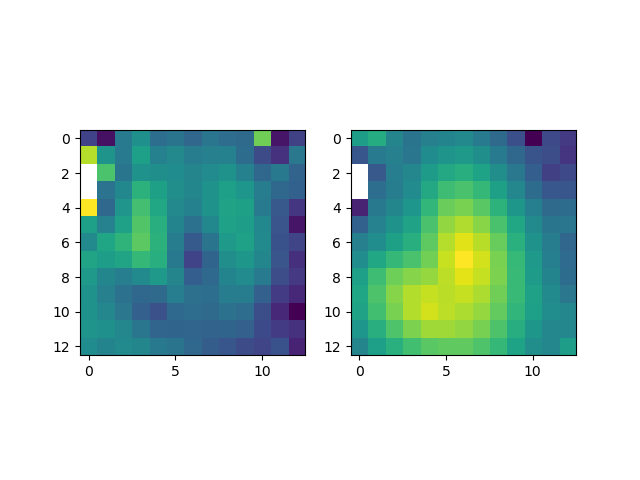

In [103]:
plt.figure()
plt.subplot(121)
plt.imshow(p-t)
plt.subplot(122)
plt.imshow(t)

<IPython.core.display.Javascript object>


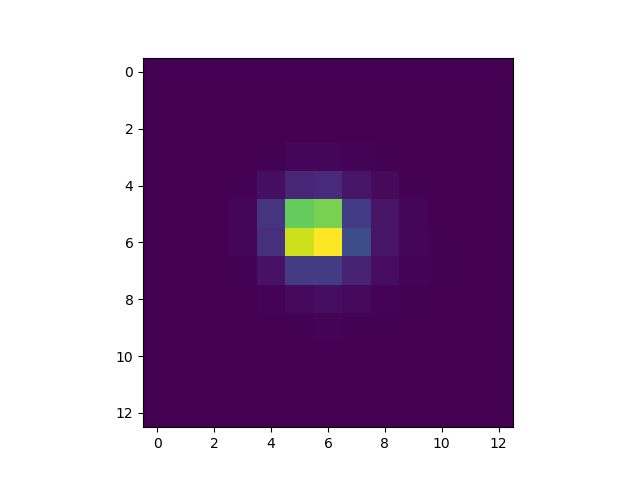

<IPython.core.display.Javascript object>


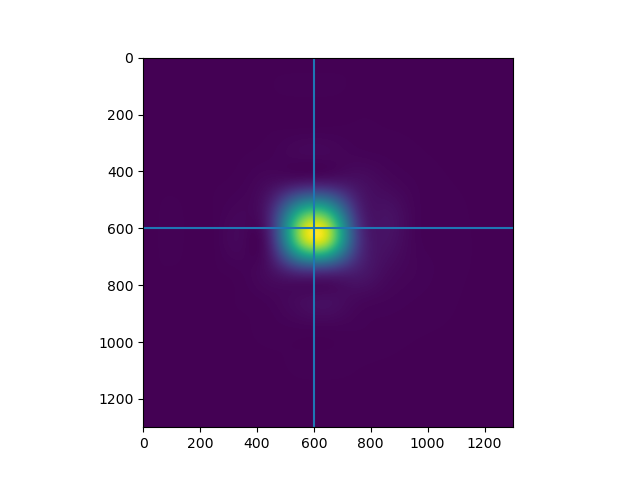

In [10]:

prf2 = sd.Interp_PRF(tpf.row,tpf.column,tpf.camera,tpf.ccd,100)
prf = sd.Get_PRF(tpf.row,tpf.column,tpf.camera,tpf.ccd)
plt.figure()
plt.imshow(prf)
plt.figure()
plt.imshow(prf2)
plt.axvline(600)
plt.axhline(600)

<IPython.core.display.Javascript object>


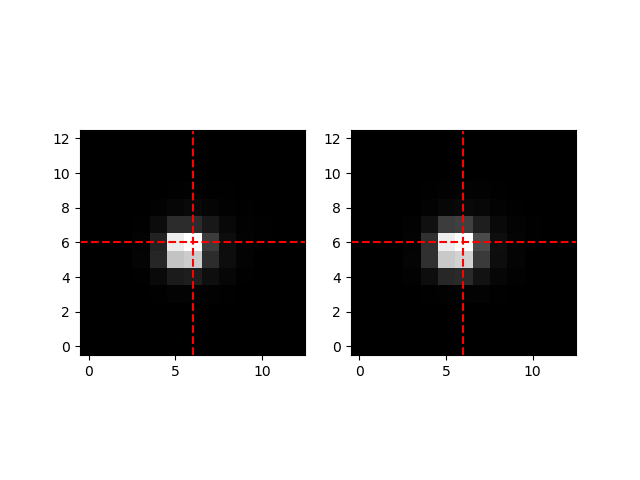

In [11]:
iprf = sd.Interp_PRF(tpf.row,tpf.column,tpf.camera,tpf.ccd,100,Method='RBS')
#iprf = np.fliplr(np.flipud(iprf))
prf = sd.Get_PRF(tpf.row,tpf.column,tpf.camera,tpf.ccd)
d = sd.Downsample(iprf,100,pix_response=False)
plt.figure()
plt.subplot(121)
plt.imshow(prf/np.nansum(prf),origin='lower',cmap='gray')
#plt.contour(iprf,extent=(-0.5,12.5,-0.5,12.5),cmap='plasma')
plt.axvline(6,ls='--',color='r')
plt.axhline(6,ls='--',color='r')
plt.subplot(122)
plt.imshow(d,origin='lower',cmap='gray')
plt.axvline(6,ls='--',color='r')
plt.axhline(6,ls='--',color='r')

<IPython.core.display.Javascript object>


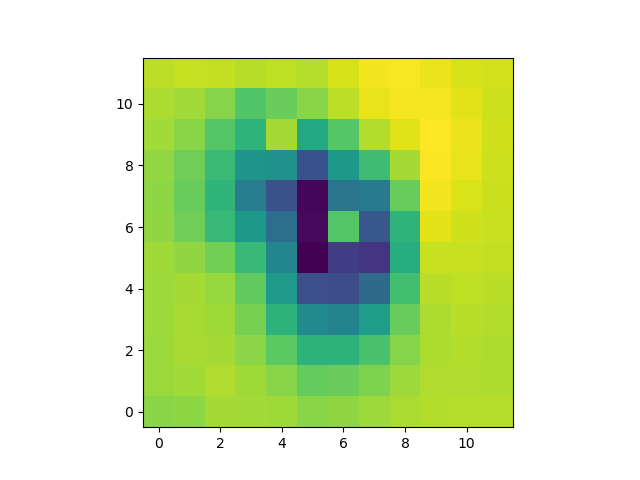

In [14]:
plt.figure()
plt.imshow(tpf.flux[100]-fra,origin='lower')

In [76]:
def Combine_PS1(coeff,ps1):
    g = ps1['g']#/100
    r = ps1['r']#/100
    i = ps1['i']#/100
    z = ps1['z']#/100
    y = ps1['y']#/100
    
    com = (coeff[0]*g + coeff[1]*r + coeff[2]*i + coeff[3]*z + coeff[4]*y)*(g/i)**coeff[5] + coeff[6]
    
    return com

def minimiser(c,ps1,tess):
    #print(c)
    z= -2.5*np.log10(ps1['z']) + 25 
    tess[tess<=0] = np.nan
    t = -2.5*np.log10(tess) + 20.44
    com = Combine_PS1(c,ps1)
    
    m = -2.5*np.log10(com) + 25
    m[(z>20) | (~np.isfinite(m))] = np.nan
    if np.nansum(m) ==0:
        return np.inf
    diff = abs(m-t)
    #plt.figure()
    gr = -2.5*np.log10(ps1['g']) + 2.5*np.log10(ps1['r'])
    
    #plt.subplot(121)
    #plt.plot(gr.flatten(),diff.flatten(),'.')
    #plt.subplot(122)
    #plt.plot(g.flatten(),diff.flatten(),'.')
    #plt.colorbar()
    res = np.nansum(diff)
    print(res)

    return res

In [77]:
tess = tpf.flux[1200]
tess = tess - np.percentile(tess,1)

In [78]:
c0 = [.25,.25,.25,.25,.25,0.1,100]
bds = [(0,1),(0,1),(0,1),(0,1),(0,1),(-10,10),(0,100)]
res = minimize(minimiser,c0,args=(down,tess),bounds=bds)

165.25396664055756
165.25396657592313
165.25396652187436
165.25396648271686
165.25396642647962
165.25396638662545
165.25396682272446
165.25396664190043
167.3619934755688
167.36199344843695
167.36199342595114
167.36199340982898
167.36199338664323
167.36199337041987
167.36199317520578
167.36199347556862
17.89437363811605
17.894373640525536
17.89437364664732
17.894373653906005
17.894373663556657
17.89437367215469
17.894373557204197
17.894373638120534
51.14192482050797
51.14192478319798
51.141924752263236
51.1419247300702
51.141924698157965
51.141924675818835
51.14192511648168
51.14192482056043
16.692238369183585
16.692238365984124
16.692238367388992
16.692238371694565
16.692238376371293
16.692238382201577
16.692238325036868
16.69223836919052
16.120163122038786
16.120163107118202
16.1201630978749
16.120163093824935
16.120163086887146
16.1201630844471
16.120163179435927
16.120163122051064
16.135488699672912
16.13548869162858
16.135488688760056
16.135488689594474
16.135488689302314
16.135488

In [80]:
res.x

array([  1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,  -4.18065772, 100.        ])

<IPython.core.display.Javascript object>


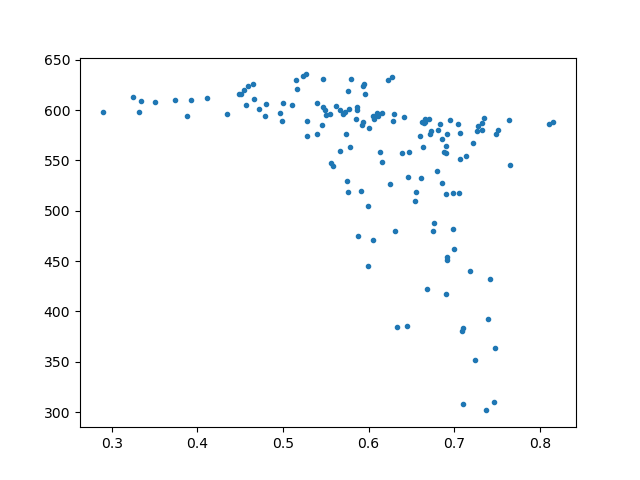

In [15]:
gr = -2.5*np.log10(down['g']) + 2.5*np.log10(down['r'])
gi = -2.5*np.log10(down['g']) + 2.5*np.log10(down['i'])
plt.figure()
plt.plot(gr.flatten(), (tpf.flux[100]-fra).flatten(),'.')

In [63]:
arg = [2.5e-01, 2.5e-01, 2.5e-01, 2.5e-01, 2.5e-01, 1.0e-01, 1.0e-08]

In [54]:
c0 = [0,.25,.25,.25,.25,0.1,100]
com = Combine_PS1(res.x,down)
d = sd.Regrid_PS1(ps1,tess_corners)

In [81]:
a = -2.5*np.log10(d['z']) + 25
c = -2.5*np.log10(com) + 25
#a = d['i']

<IPython.core.display.Javascript object>


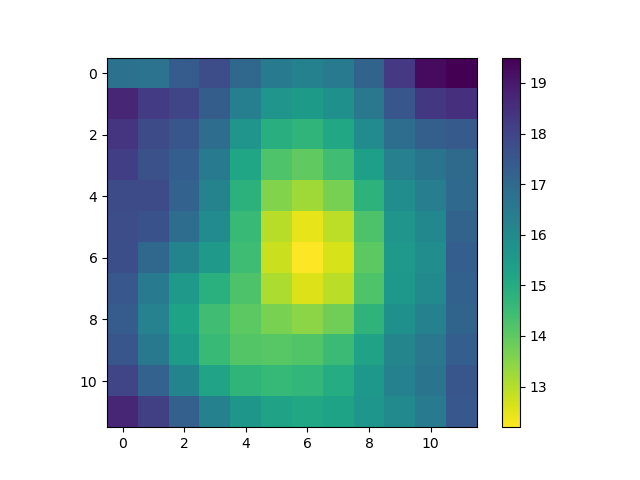

In [82]:
plt.figure()
plt.imshow(c,cmap='viridis_r')
plt.colorbar()

In [24]:
b = -2.5*np.log10(ps1['i']) + 25
b[~np.isfinite(b)] = 21

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


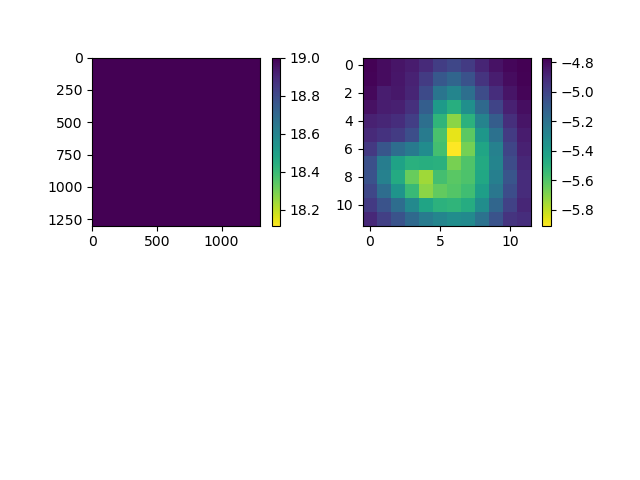

In [25]:
plt.figure()
plt.subplot(221)
plt.imshow(b,cmap='viridis_r',vmax=19)
plt.colorbar()
plt.subplot(222)
plt.imshow(-2.5*np.log10(tess)+20.44-c,cmap='viridis_r')
plt.colorbar()

<IPython.core.display.Javascript object>


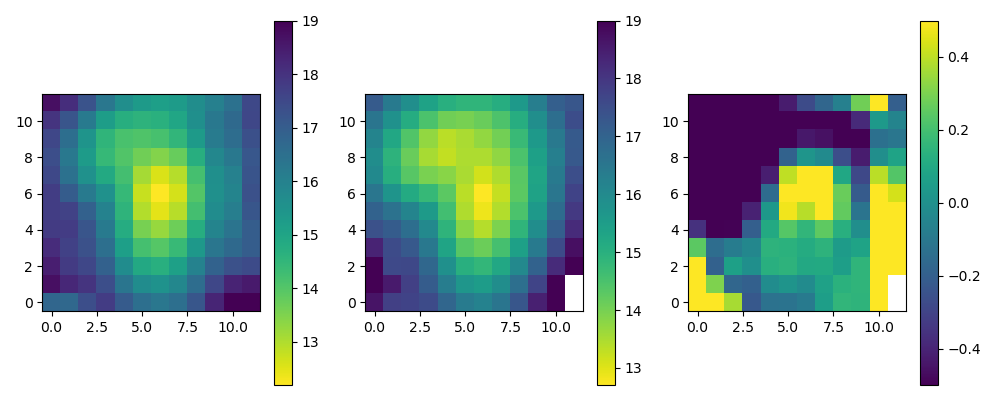

In [83]:
t = -2.5*np.log10(tess)+20.44
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(c,cmap='viridis_r',vmax=19,origin='lower')
plt.colorbar()
plt.subplot(132)
plt.imshow(t,cmap='viridis_r',vmax=19,origin='lower')
plt.colorbar()

plt.subplot(133)
plt.imshow(t-c,origin='lower',vmin=-.5,vmax=.5)
plt.colorbar()
plt.tight_layout()

In [162]:
tess = tpf.flux[100].value - 603
psd = sd.Regrid_PS1(ps1,tess_corners)


In [179]:
down = sd.Regrid_PS(ps1['tess'],tess_corners).T
x0 = [5,5,10,10,0,np.log(np.nansum(down) / np.nansum(tess))]
bds = [[3,7],[3,7],[1,100],[1,100],[-np.pi/2,np.pi/2],[-100,100]]
res = minimize(fit_psf,x0,args=(ps1,tpf.flux[100].value,tess_corners),method='Powell',bounds=bds)

[ 5.          5.         10.         10.          0.          3.45275844]
diff  3.237739654143141e+16
[ 4.52786405  5.         10.         10.          0.          3.45275844]
diff  3.236747675872505e+16
[ 5.47213595  5.         10.         10.          0.          3.45275844]
diff  3.2392177374758464e+16
[ 3.94427191  5.         10.         10.          0.          3.45275844]
diff  3.2361951498189892e+16
[ 3.80273318  5.         10.         10.          0.          3.45275844]
diff  3.2361735170356816e+16
[ 3.80370459  5.         10.         10.          0.          3.45275844]
diff  3.236173515924833e+16
[ 3.80374084  5.         10.         10.          0.          3.45275844]
diff  3.236173515923397e+16
[ 3.80377419  5.         10.         10.          0.          3.45275844]
diff  3.236173515924613e+16
[ 3.80374084  4.52786405 10.         10.          0.          3.45275844]
diff  3.2496930135814344e+16
[ 3.80374084  5.47213595 10.         10.          0.          3.45275844]
diff

[ 3.80374084  6.99993758 99.99995978 99.98493488  0.          3.45275844]
diff  3.0910778677827844e+16
[ 3.80374084  6.99993758 99.99995978 99.99068924  0.          3.45275844]
diff  3.0910778475746916e+16
[ 3.80374084  6.99993758 99.99995978 99.99424564  0.          3.45275844]
diff  3.0910778350871576e+16
[ 3.80374084  6.99993758 99.99995978 99.99644361  0.          3.45275844]
diff  3.0910778273701092e+16
[ 3.80374084  6.99993758 99.99995978 99.99780203  0.          3.45275844]
diff  3.091077822600969e+16
[ 3.80374084  6.99993758 99.99995978 99.99864158  0.          3.45275844]
diff  3.091077819653571e+16
[ 3.80374084  6.99993758 99.99995978 99.99916045  0.          3.45275844]
diff  3.0910778178320172e+16
[ 3.80374084  6.99993758 99.99995978 99.99948113  0.          3.45275844]
diff  3.0910778167062492e+16
[ 3.80374084  6.99993758 99.99995978 99.99967932  0.          3.45275844]
diff  3.091077816010492e+16
[ 3.80374084  6.99993758 99.99995978 99.99980181  0.          3.45275844]
di

[ 3.36067977  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8554512.043730976
[ 3.22291236  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8552515.204511523
[ 3.13776741  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8551429.683096597
[ 3.08514495  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8550815.553464867
[ 3.05262247  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8550457.68109721
[ 3.03252248  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8550244.785161281
[ 3.02009999  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8550116.37145196
[ 3.01242248  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8550038.21566035
[ 3.00767751  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8549990.37423447
[ 3.00474497  5.15128956 16.80823971 16.80823965  0.02684247 -0.80156949]
diff  8549960.982888497
[ 3.00293255  5.15128956

[ 3.00006242e+00  3.00006242e+00  8.38370745e+00  9.99939137e+01
  2.68424711e-02 -8.01569493e-01]
diff  8135660.544732237
[ 3.00006242e+00  3.00006242e+00  8.38370745e+00  9.99962385e+01
  2.68424711e-02 -8.01569493e-01]
diff  8135660.509097194
[ 3.00006242e+00  3.00006242e+00  8.38370745e+00  9.99976753e+01
  2.68424711e-02 -8.01569493e-01]
diff  8135660.487074809
[ 3.00006242e+00  3.00006242e+00  8.38370745e+00  9.99985632e+01
  2.68424711e-02 -8.01569493e-01]
diff  8135660.473464713
[ 3.00006242e+00  3.00006242e+00  8.38370745e+00  9.99991120e+01
  2.68424711e-02 -8.01569493e-01]
diff  8135660.465053398
[ 3.00006242e+00  3.00006242e+00  8.38370745e+00  9.99994512e+01
  2.68424711e-02 -8.01569493e-01]
diff  8135660.459854989
[ 3.00006242e+00  3.00006242e+00  8.38370745e+00  9.99996608e+01
  2.68424711e-02 -8.01569493e-01]
diff  8135660.456642228
[ 3.00006242e+00  3.00006242e+00  8.38370745e+00  9.99997904e+01
  2.68424711e-02 -8.01569493e-01]
diff  8135660.454656639
[ 3.00006242e+00

[ 4.18683579e+00  3.00042785e+00  8.38662307e+00  9.99989097e+01
 -6.70158378e-02 -8.03163834e-01]
diff  7964401.549704811
[ 4.18683579e+00  3.00026443e+00  8.38662307e+00  9.99989097e+01
 -6.70158378e-02 -8.03163834e-01]
diff  7964401.408604164
[ 4.18683579e+00  3.00016343e+00  8.38662307e+00  9.99989097e+01
 -6.70158378e-02 -8.03163834e-01]
diff  7964401.321412737
[ 4.18683579e+00  3.00010100e+00  8.38662307e+00  9.99989097e+01
 -6.70158378e-02 -8.03163834e-01]
diff  7964401.267530653
[ 4.18683579e+00  3.00006242e+00  8.38662307e+00  9.99989097e+01
 -6.70158378e-02 -8.03163834e-01]
diff  7964401.234231673
[ 4.18684109e+00  3.00005355e+00  8.38622394e+00  9.99985105e+01
 -6.70174114e-02 -8.02914425e-01]
diff  7964251.680685139
[ 4.18684109  3.00005355  8.38622394 38.81463511 -0.06701741 -0.80291443]
diff  7964086.96204284
[ 4.18684109  3.00005355  8.38622394 62.18536489 -0.06701741 -0.80291443]
diff  7964077.321009546
[ 4.18684109e+00  3.00005355e+00  8.38622394e+00  7.66292702e+01
 -

In [59]:
from PRF import TESS_PRF

In [129]:
from astropy.modeling.functional_models import Gaussian2D

In [147]:
g2d = Gaussian2D(x_mean=5,y_mean=5,x_stddev=2,y_stddev=3,theta=.1)
g = g2d(XX,YY)

<IPython.core.display.Javascript object>


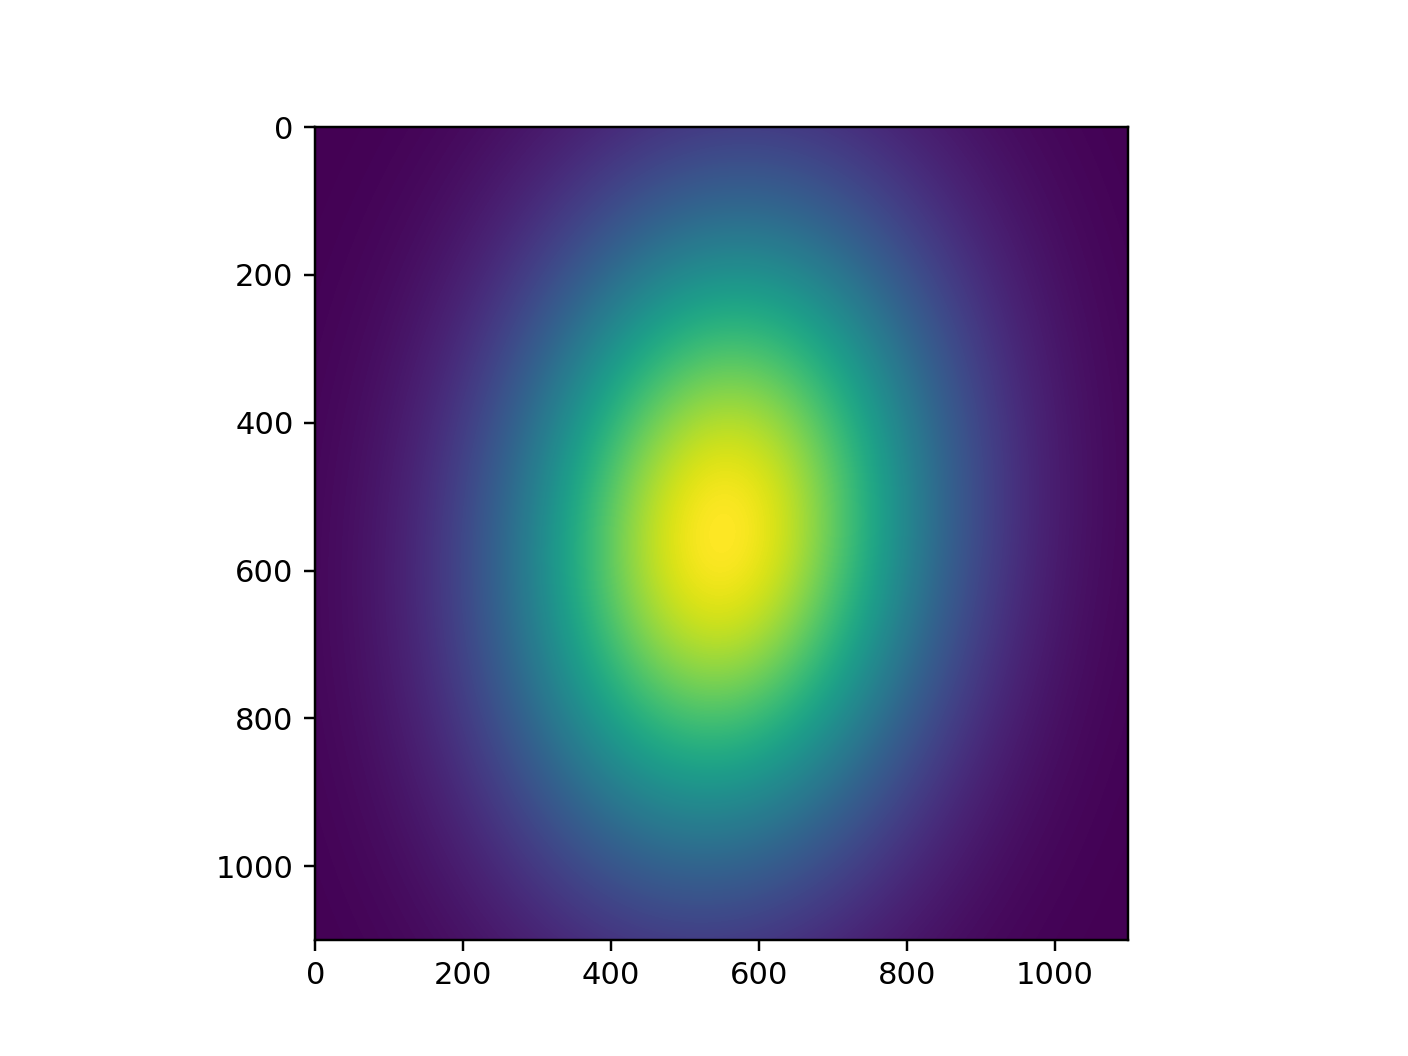

In [148]:
plt.figure()
plt.imshow(g)

In [127]:
p = prf

X = np.arange(0,prf.shape[1],1e-2)
Y = np.arange(0,prf.shape[0],1e-2)
XX, YY = np.meshgrid(X-0.5,Y-0.5)
x = np.arange(0,prf.shape[1])
y = np.arange(0,prf.shape[0])
xx, yy = np.meshgrid(x, y)
XX, YY = np.meshgrid(X-0.5,Y-0.5)

estimate = griddata((xx.ravel(), yy.ravel()), p.ravel(),
                    (XX.ravel(),YY.ravel()),method='linear',fill_value=0)

estimate = estimate.reshape(len(Y),len(X))
estimate /= np.nansum(estimate)

<IPython.core.display.Javascript object>


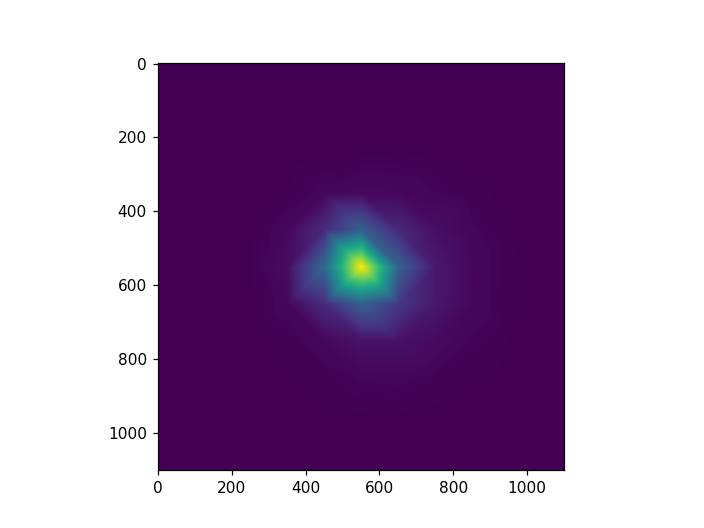

<IPython.core.display.Javascript object>


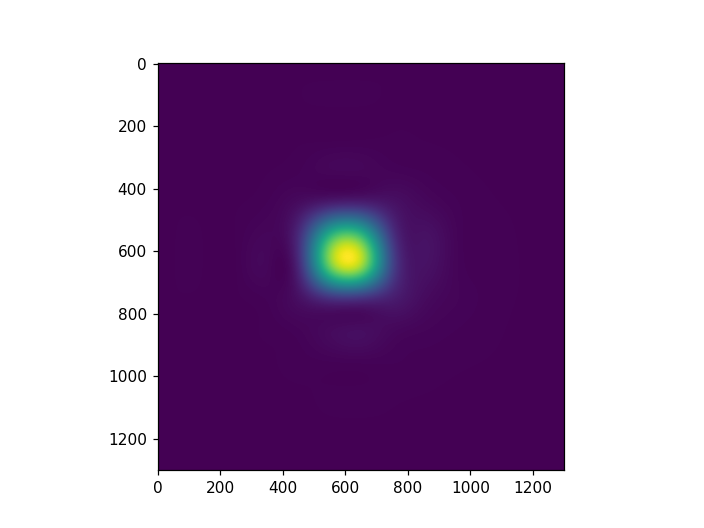

In [128]:
plt.figure()
plt.imshow(estimate)
plt.figure()
plt.imshow(PRF)